<a href="https://colab.research.google.com/github/maaz1m/image-classification/blob/main/Image_Classification_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Model for image classification



In [ ]:
# Importing the required libraries

import keras
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K

from sklearn.model_selection import train_test_split
from IPython.display import display

import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import os
import glob

## 1.1   Loading dataset

In [ ]:
# Load dataset through wget

!wget -O cifar10.zip 'https://pern-my.sharepoint.com/:u:/g/personal/20100068_lums_edu_pk/EYUkeEvBglhMkPOdvdJMsOUB2u8c0qE1EtfJtz6EoUf_fQ?download=1'
!unzip cifar10.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/cifar/test/1880_automobile.png  
  inflating: images/cifar/test/1905_cat.png  
  inflating: images/cifar/test/1893_truck.png  
  inflating: images/cifar/test/1867_frog.png  
  inflating: images/cifar/test/1862_dog.png  
  inflating: images/cifar/test/1860_ship.png  
  inflating: images/cifar/test/1854_dog.png  
  inflating: images/cifar/test/183_bird.png  
  inflating: images/cifar/test/1839_horse.png  
  inflating: images/cifar/test/1825_bird.png  
  inflating: images/cifar/test/1815_truck.png  
  inflating: images/cifar/test/1812_dog.png  
 extracting: images/cifar/test/1802_bird.png  
  inflating: images/cifar/test/1801_deer.png  
  inflating: images/cifar/test/1800_deer.png  
  inflating: images/cifar/test/178_dog.png  
  inflating: images/cifar/test/1786_automobile.png  
  inflating: images/cifar/test/1782_cat.png  
  inflating: images/cifar/test/1780_horse.png  
  inflating: images/cifar/test/1765_deer.png  
 

In [ ]:
# Set hyperparameters and initialize variables

batch_size = 64
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
input_shape_cifar = (32,32,3)
images_dir = './images/cifar/'
epochs = 25
all_histories = []

In [ ]:
# Split data into x and y and train and test

train_dir = images_dir + 'train/'
test_dir = images_dir + 'test/'
label_file = images_dir + 'labels.txt'

# Get full path of the file names in the dataset
train_files = [os.path.join(train_dir, f) for f in os.listdir(train_dir)]
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

classes = open(label_file).read().split('\n')

def getLabelFromPath(p):
    class_name = p.split('_')[-1].replace('.png', '')
    return classes.index(class_name)

# Convert class names to categorical
y_train_labels = [getLabelFromPath(f) for f in train_files]
y_train = keras.utils.to_categorical(y_train_labels, num_classes)
x_train = train_files
y_test_labels = [getLabelFromPath(f) for f in test_files]
y_test = keras.utils.to_categorical(y_test_labels, num_classes)
x_test = test_files

# Split into train set and test set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

print("x_train length:\t", len(x_train))
print("y_train length:\t", len(y_train))
print("x_val length:\t", len(x_val))
print("y_val length:\t", len(y_val))

x_train length:	 40000
y_train length:	 40000
x_val length:	 10000
y_val length:	 10000


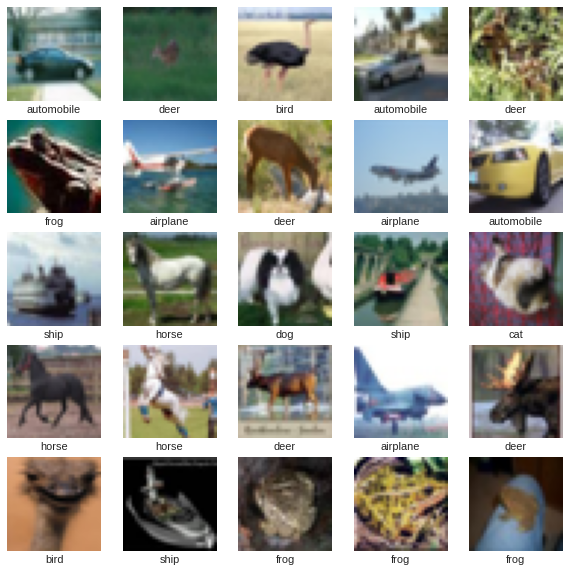

In [ ]:
# Visualize dataset

def read_image(filepath):
    im = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    return im.reshape(input_shape_cifar)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    impath = x_train[i]
    plt.imshow(read_image(impath), cmap=plt.cm.binary)
    plt.xlabel(impath.split('_')[-1].replace('.png', ''))
plt.show()

## 1.3  Batch Generator

In [ ]:
# Define function for batch generator since we will not be loading the entire dataset into memory

def data_generator(images_paths, labels, batch_size = 32, preprocessing = None):
    indexes = np.arange(0, len(images_paths), batch_size)
    if len(images_paths) % batch_size != 0:
        indexes = indexes[:-1]
    np.random.shuffle(indexes)
    
    while 1:

        for index in indexes:

            batch_start = index
            batch_end = index + batch_size

            batch_x = []
            batch_y = []

            for i in range(batch_start, batch_end):

                batch_y.append(labels[i])

                batch_x.append(read_image(images_paths[i]))

            batch_x = np.array(batch_x)
            batch_y = np.array(batch_y).reshape(batch_size,num_classes)

            if (preprocessing == 'norm'):
                batch_x = preprocessing_norm(batch_x)
            else:
                pass

            yield (batch_x, batch_y)

## 1.4 Model Design

In [ ]:
# Define layers

input_img = Input(shape=(input_shape_cifar), name='input_img')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_img)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model_initial = Model(inputs=input_img, outputs=output_class)

In [ ]:
# Define optimizer and compile model

model_name = 'base_model'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

adam = Adam(lr=0.001)

model_initial.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])   

In [ ]:
# Summarise the model layers

model_initial.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 44)                34540     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                450       
Total params: 36,382
Trainable params: 36,382
Non-trainable params: 0
_________________________________________________________

## 1.5 Model Training

In [ ]:
# Add callbacks

class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, csvlogger, reducelr, tensorboard]

#### 1.5.1 Base model

In [ ]:
# Create the various generators

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = None)
val_gen = data_generator(x_val, y_val, batch_size, preprocessing = None)
test_gen = data_generator(x_test, y_test, batch_size, preprocessing = None)

In [ ]:
# Train model

hist_initial = model_initial.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)

all_histories.append(hist_initial)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
625/625 [==============================] - 14s 12ms/step - loss: 4.0133 - accuracy: 0.1768 - val_loss: 1.8567 - val_accuracy: 0.2896

Epoch 00001: val_loss improved from inf to 1.85668, saving model to base_model/base_model-01-1.86.h5
Epoch 2/25
625/625 [==============================] - 7s 11ms/step - loss: 1.8096 - accuracy: 0.3156 - val_loss: 1.6801 - val_accuracy: 0.3748

Epoch 00002: val_loss improved from 1.85668 to 1.68009, saving model to base_model/base_model-02-1.68.h5
Epoch 3/25
625/625 [==============================] - 7s 11ms/step - loss: 1.6311 - accuracy: 0.3924 - val_loss: 1.5851 - val_accuracy: 0.4230

Epoch 00003: val_loss improved from 1.68009 to 1.58515, saving model to base_model/base_model-03-1.59.h5
Epoch 4/25
625/625 [==============================] - 7s 11ms/step - loss: 1.5171 - accuracy: 0.4411 - val_loss: 1.5173 - val_accuracy: 0.4572

Epoch 00004: val_loss improved from 1.58515 to 1.51729, saving model to base_model/base_model-04-1.52.h5
Epoch 5

#### 1.5.2 Model with normalization

In [ ]:
# Define the normalization function

def preprocessing_norm(images):
    processed_images = images / 255.0
    return processed_images

In [ ]:
# Train model with normalization

input_img = Input(shape=(input_shape_cifar), name='input_img')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_img)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model_preprocessed = Model(inputs=input_img, outputs=output_class)

model_name = 'model_preprocessed_input'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

adam = Adam(lr=0.001)

model_preprocessed.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model_preprocessed, model_name+'/'+model_name+'.png')

model_preprocessed.summary()

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, csvlogger, reducelr, tensorboard]

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = 'norm')
val_gen = data_generator(x_val, y_val, batch_size, preprocessing = 'norm')
test_gen = data_generator(x_test, y_test, batch_size, preprocessing = 'norm')

hist_preprocessed = model_preprocessed.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_preprocessed)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          1168      
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 44)                34540     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                450       
Total params: 36,382
Trainable params: 36,382
Non-trainable params: 0
_______________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


625/625 [==============================] - 8s 12ms/step - loss: 1.9346 - accuracy: 0.2975 - val_loss: 1.5251 - val_accuracy: 0.4576

Epoch 00001: val_loss improved from inf to 1.52509, saving model to model_preprocessed_input/model_preprocessed_input-01-1.53.h5
Epoch 2/25
625/625 [==============================] - 7s 12ms/step - loss: 1.4910 - accuracy: 0.4677 - val_loss: 1.4214 - val_accuracy: 0.4899

Epoch 00002: val_loss improved from 1.52509 to 1.42140, saving model to model_preprocessed_input/model_preprocessed_input-02-1.42.h5
Epoch 3/25
625/625 [==============================] - 8s 12ms/step - loss: 1.3963 - accuracy: 0.5049 - val_loss: 1.3814 - val_accuracy: 0.5023

Epoch 00003: val_loss improved from 1.42140 to 1.38145, saving model to model_preprocessed_input/model_preprocessed_input-03-1.38.h5
Epoch 4/25
625/625 [==============================] - 8s 12ms/step - loss: 1.3380 - accuracy: 0.5228 - val_loss: 1.3499 - val_accuracy: 0.5153

Epoch 00004: val_loss improved from 1.38

# 2 Model with max pooling layer

In [ ]:
# Add max pooling layer and train model

input_img = Input(shape=(input_shape_cifar), name='input_img')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_img)
pool1 = MaxPooling2D(pool_size=(2, 2), strides = (2, 2), data_format='channels_last')(conv1)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(pool1)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model_pooled = Model(inputs=input_img, outputs=output_class)

model_name = 'model_pooling'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

adam = Adam(lr=0.001)

model_pooled.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model_pooled, model_name+'/'+model_name+'.png')

model_pooled.summary()

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, csvlogger, reducelr, tensorboard]

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = 'norm')
val_gen = data_generator(x_val, y_val, batch_size, preprocessing = 'norm')
test_gen = data_generator(x_test, y_test, batch_size, preprocessing = 'norm')

hist_pooled = model_pooled.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_pooled)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 16)          1168      
_________________________________________________________________
flatten_2 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 44)                6380      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                450 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


625/625 [==============================] - 8s 13ms/step - loss: 2.0252 - accuracy: 0.2457 - val_loss: 1.6540 - val_accuracy: 0.4072

Epoch 00001: val_loss improved from inf to 1.65397, saving model to model_pooling/model_pooling-01-1.65.h5
Epoch 2/25
625/625 [==============================] - 8s 12ms/step - loss: 1.6012 - accuracy: 0.4218 - val_loss: 1.5021 - val_accuracy: 0.4654

Epoch 00002: val_loss improved from 1.65397 to 1.50210, saving model to model_pooling/model_pooling-02-1.50.h5
Epoch 3/25
625/625 [==============================] - 8s 12ms/step - loss: 1.4834 - accuracy: 0.4681 - val_loss: 1.4391 - val_accuracy: 0.4862

Epoch 00003: val_loss improved from 1.50210 to 1.43912, saving model to model_pooling/model_pooling-03-1.44.h5
Epoch 4/25
625/625 [==============================] - 8s 12ms/step - loss: 1.4276 - accuracy: 0.4936 - val_loss: 1.4093 - val_accuracy: 0.4979

Epoch 00004: val_loss improved from 1.43912 to 1.40930, saving model to model_pooling/model_pooling-04-1.4

# 3 Model with dropout layer

In [ ]:
# Add dropout layer and train model

input_img = Input(shape=(input_shape_cifar), name='input_img')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_img)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(conv1)
flat = Flatten()(conv2)
drop1 = Dropout(rate=0.3, seed=your_id)(flat)
dense1 = Dense(44, activation='relu')(drop1)
output_class = Dense(num_classes, activation='softmax')(dense1)

model_dropout = Model(inputs=input_img, outputs=output_class)

model_name = 'model_dropout'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

adam = Adam(lr=0.001)

model_dropout.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model_dropout, model_name+'/'+model_name+'.png')

model_dropout.summary()

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, csvlogger, reducelr, tensorboard]

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = 'norm')
val_gen = data_generator(x_val, y_val, batch_size, preprocessing = 'norm')
test_gen = data_generator(x_test, y_test, batch_size, preprocessing = 'norm')

hist_dropout = model_dropout.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_dropout)


NameError: ignored

# 4 Model with batch normalization


In [ ]:
# Add batch normalization layer and train model

input_img = Input(shape=(input_shape_cifar), name='input_img')
conv1 = Conv2D(8, kernel_size=(3, 3), strides = (2,2),  activation='relu')(input_img)
normalized = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, 
                                scale=True, beta_initializer='zeros', 
                                gamma_initializer='ones', moving_mean_initializer='zeros', 
                                moving_variance_initializer='ones', beta_regularizer=None, 
                                gamma_regularizer=None, beta_constraint=None, 
                                gamma_constraint=None)(conv1)
conv2 = Conv2D(16, (3, 3), strides = (2,2), activation='relu')(normalized)
flat = Flatten()(conv2)
dense1 = Dense(44, activation='relu')(flat)
output_class = Dense(num_classes, activation='softmax')(dense1)

model_batch_normalized = Model(inputs=input_img, outputs=output_class)

model_name = 'model_batch_normalized'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

adam = Adam(lr=0.001)

model_batch_normalized.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model_batch_normalized, model_name+'/'+model_name+'.png')

model_batch_normalized.summary()

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, csvlogger, reducelr, tensorboard]

train_gen = data_generator(x_train, y_train, batch_size, preprocessing = 'norm')
val_gen = data_generator(x_val, y_val, batch_size, preprocessing = 'norm')
test_gen = data_generator(x_test, y_test, batch_size, preprocessing = 'norm')

hist_batch_normalized = model_batch_normalized.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(y_train)//batch_size, 
                           validation_data=val_gen, validation_steps=len(y_val)//batch_size, 
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_batch_normalized)


# 5 Comparison

In [ ]:
# Plot accuracy of all models
def plotHistory(histories, names, metric):
    plt.clf() 
    x_axis = list(range(epochs))
    for hist, name in zip(histories, names):
        plt.plot(x_axis, hist.history[metric], label=metric+'_'+name)
        plt.scatter(x_axis, hist.history[metric])
    plt.legend()
    plt.title(metric)
    plt.show()

In [ ]:
labels = ['Base', 'Normalized', 'MaxPooling', 'Dropout', 'BatchNormalized']

In [ ]:
# Plot histories of all modelsm
plt.clf() 
x_axis = list(range(epochs))

for i in range(len(labels)):
    plt.plot(x_axis, all_histories[i].history['accuracy'], label=labels[i])
    plt.scatter(x_axis, all_histories[i].history['accuracy'])

plt.legend()
plt.title('Accuracy')
plt.show()


# plot loss of all models
plt.clf() 
x_axis = list(range(epochs))

for i in range(len(labels)):
    plt.plot(x_axis, all_histories[i].history['loss'], label=labels[i])
    plt.scatter(x_axis, all_histories[i].history['loss'])

plt.legend()
plt.title('Loss')
plt.show()